**Project Objective:**

In this project, we forecast sales for the next 3 months for 50 different products across 10 different stores using 5 years of store-item sales data. The dataset includes daily sales figures for each store and product. We've applied various techniques to analyze this time series data and predict future demand using machine learning methods.

**Key Highlights:**

- **Model Utilization:** Employed the LightGBM algorithm for sales forecasting. LightGBM is effective in handling large datasets and provides high accuracy.
  
- **Time Series Features:** To enhance model accuracy, we created several key date features:
  - **Exponentially Weighted Mean (EWM):** I computed the exponentially weighted mean on sales data. This method gives more weight to recent data, making the model more sensitive to recent changes and improving prediction accuracy.
  - **Rolling Mean:** I calculated rolling mean to better model trends and seasonality effects.
  - **Lag Features:** I created lag features using past sales data to incorporate historical performance into the model.
  
- **Time Series Analysis:** We processed time series data by considering seasonal patterns, trends, and cyclical effects.

In this project, we achieved high accuracy in sales predictions by applying techniques such as EWM, rolling mean, and lag features to time series data. 

In [0]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from tabulate import tabulate

import plotly.graph_objs as go
import plotly

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [0]:
#SET GLOBAL FLAG
should_continue_execution = True  # Default to True

In [0]:
#Widgets used to pass value
dbutils.widgets.text("job-id", "100")
dbutils.widgets.text("postback-url", "")
dbutils.widgets.text("rb_detail", "")
dbutils.widgets.text("rb_summary", "")

jobId = dbutils.widgets.get("job-id")
rb_detail = dbutils.widgets.get("rb_detail")
rb_summary = dbutils.widgets.get("rb_summary")
webserverURL = dbutils.widgets.get("postback-url")

#print(f"parameter_value for key rb_summary is: {rb_summary} and parameter_value for key rb_detail is: {rb_detail}")

#Initialize and Start Execution
from fire_notebook.output.workflowcontext import RestWorkflowContext
restworkflowcontext = RestWorkflowContext(webserverURL, jobId)
message="20"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

Sending Message: {"progress": "20", "id": 9, "name": "Progress", "title": "Progress", "type": "progress", "resultType": 3, "visibility": "EXPANDED", "time": "Aug 19, 2024 11:40:43 AM"}
Not sending message to fire_notebook server as the post back URL is not http

### EDA Functions

In [0]:
# Define the check_df function
def check_df(dataframe: pd.DataFrame, head: int = 5) -> None:
    # Print DataFrame shape
    htmlstr1 = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
        <h3>DataFrame Shape</h3>
        <p>Rows: {dataframe.shape[0]}, Columns: {dataframe.shape[1]}</p>
    </div>
    """
    restworkflowcontext.outHTML(9, title="DataFrame Shape", text=htmlstr1)

    # Print DataFrame unique values in HTML format
    unique_values = dataframe.nunique().reset_index()
    unique_values.columns = ['Column', 'Unique Values']
    unique_values_html = unique_values.to_html(index=False, border=0, classes='table table-striped')

    # Extract only the <tbody> section from the generated HTML
    tbody_start = unique_values_html.find('<tbody>')
    tbody_end = unique_values_html.find('</tbody>') + len('</tbody>')
    unique_values_tbody = unique_values_html[tbody_start:tbody_end]

    unique_values_html_full = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
        <table class="table table-striped" id="unique_values_table" style="width: 100%; text-align: left;">
            <thead style="text-align: left;">
                <tr>
                    <th>Column</th>
                    <th>Unique Values</th>
                </tr>
            </thead>
            {unique_values_tbody}
        </table>
    </div>
    """
    restworkflowcontext.outHTML(10, title="Unique Values Per Column", text=unique_values_html_full)

    # Print DataFrame data types
    data_types = dataframe.dtypes.reset_index()
    data_types.columns = ['Column', 'Data Type']
    data_types_html = data_types.to_html(index=False, border=0, classes='table table-striped')

    # Extract only the <tbody> section from the generated HTML
    tbody_start = data_types_html.find('<tbody>')
    tbody_end = data_types_html.find('</tbody>') + len('</tbody>')
    data_types_tbody = data_types_html[tbody_start:tbody_end]

    data_types_html_full = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
        <table class="table table-striped" id="data_types_table" style="width: 100%; text-align: left;">
            <thead style="text-align: left;">
                <tr>
                    <th>Column</th>
                    <th>Data Type</th>
                </tr>
            </thead>
            {data_types_tbody}
        </table>
    </div>
    """
    restworkflowcontext.outHTML(11, title="Data Types", text=data_types_html_full)

    # Print head of the DataFrame
    head_html = dataframe.head().to_html(index=False, border=0, classes='table table-striped')

    # Extract only the <tbody> section from the generated HTML
    tbody_start = head_html.find('<tbody>')
    tbody_end = head_html.find('</tbody>') + len('</tbody>')
    head_tbody = head_html[tbody_start:tbody_end]

    head_html_full = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
        <table class="table table-striped" id="head_table" style="width: 100%; text-align: left;">
            <thead style="text-align: left;">
                <tr>
                    {"".join(f"<th>{col}</th>" for col in dataframe.columns)}
                </tr>
            </thead>
            {head_tbody}
        </table>
    </div>
    """
    restworkflowcontext.outHTML(12, title="Top Rows (Head)", text=head_html_full)

    # Print tail of the DataFrame
    tail_html = dataframe.tail().to_html(index=False, border=0, classes='table table-striped')

    # Extract only the <tbody> section from the generated HTML
    tbody_start = tail_html.find('<tbody>')
    tbody_end = tail_html.find('</tbody>') + len('</tbody>')
    tail_tbody = tail_html[tbody_start:tbody_end]

    tail_html_full = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
        <table class="table table-striped" id="tail_table" style="width: 100%; text-align: left;">
            <thead style="text-align: left;">
                <tr>
                    {"".join(f"<th>{col}</th>" for col in dataframe.columns)}
                </tr>
            </thead>
            {tail_tbody}
        </table>
    </div>
    """
    restworkflowcontext.outHTML(13, title="Bottom Rows (Tail)", text=tail_html_full)    

    # Print missing values
    missing_values = dataframe.isnull().sum().reset_index()
    missing_values.columns = ['Column', 'Missing Values']
    missing_values_html = missing_values.to_html(index=False, border=0, classes='table table-striped')

# Extract only the <tbody> section from the generated HTML
    tbody_start = missing_values_html.find('<tbody>')
    tbody_end = missing_values_html.find('</tbody>') + len('</tbody>')
    missing_values_tbody = missing_values_html[tbody_start:tbody_end]

    missing_values_html_full = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
        <table class="table table-striped" id="missing_values_table" style="width: 100%; text-align: left;">
            <thead style="text-align: left;">
                <tr>
                    <th>Column</th>
                    <th>Missing Values</th>
                </tr>
            </thead>
            {missing_values_tbody}
        </table>
    </div>
    """
    restworkflowcontext.outHTML(14, title="Missing Values Per Column", text=missing_values_html_full)

    # Print date range if 'date' column exists
    if 'date' in dataframe.columns and pd.api.types.is_datetime64_any_dtype(dataframe['date']):
        date_range_html = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <h3>Date Range</h3>
            <p>Start Date: {dataframe['date'].min()}</p>
            <p>End Date: {dataframe['date'].max()}</p>
        </div>
        """
        restworkflowcontext.outHTML(15, title="Date Range", text=date_range_html)

    # Print quantile statistics
    quantiles = dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T.reset_index()
    quantiles_html = quantiles.to_html(index=False, border=0, classes='table table-striped')

    # Extract only the <tbody> section from the generated HTML
    tbody_start = quantiles_html.find('<tbody>')
    tbody_end = quantiles_html.find('</tbody>') + len('</tbody>')
    quantiles_tbody = quantiles_html[tbody_start:tbody_end]

    quantiles_html_full = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
        <table class="table table-striped" id="quantiles_table" style="width: 100%; text-align: left;">
            <thead style="text-align: left;">
                <tr>
                    {"".join(f"<th>{col}</th>" for col in quantiles.columns)}
                </tr>
            </thead>
            {quantiles_tbody}
        </table>
    </div>
    """
    restworkflowcontext.outHTML(16, title="Quantiles", text=quantiles_html_full)


# target summary with cat cols
# Function to see the average sales for each store and the average sales for each item.
#Example Business Questions that can be answered:
    #Which store has the highest average sales value?
    #Which item has the lowest average sales value?

def target_summary_with_cat(dataframe, target, categorical_cols):
    for col in categorical_cols:
        summary_df = dataframe.groupby(col)[target].mean().reset_index()
        summary_df.columns = [col, "TARGET_MEAN"]

        # Convert DataFrame to HTML
        summary_html = summary_df.to_html(index=False, border=0, classes='table table-striped')

        # Extract <tbody> section (optional, for styling)
        tbody_start = summary_html.find('<tbody>')
        tbody_end = summary_html.find('</tbody>') + len('</tbody>')
        summary_tbody = summary_html[tbody_start:tbody_end]

        # Wrap HTML in a div for styling (optional)
        summary_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="summary_table" style="width: 100%; text-align: left;">
                <thead>
                    <tr>
                        <th>{col}</th>
                        <th>TARGET_MEAN</th>
                    </tr>
                </thead>
                {summary_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(16, title="Detailed Report", text=summary_html_full)

        print(summary_df, end="\n\n\n")

        # Create histogram
        plt.figure(figsize=(15, 6))
        plt.bar(summary_df[col].astype(str), summary_df["TARGET_MEAN"], color='skyblue')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.title(f"{target} mean for {col}")
        plt.xticks(rotation=45)
        plt.show()
        #fig = plotly.offline.plot([go.Bar(x=summary_df[col], y=summary_df["TARGET_MEAN"])], output_type='div', include_plotlyjs=False)
        #example_plotly = f'{fig}'
        #restworkflowcontext.outPlotly(9, title="MEAN OF", text=example_plotly )
        #fig = go.Figure(data=[go.Bar(x=summary_df[col], y=summary_df["TARGET_MEAN"])])
        fig = go.Figure(data=[go.Bar(x=summary_df[col], y=summary_df["TARGET_MEAN"], marker_color='skyblue')])
        fig.update_layout(
            #title=f"{target} mean for {col}",
            xaxis_title=col,
            yaxis_title=target
        )

        # Display the chart (replace with your output method)
        fig_html = plotly.offline.plot(fig, output_type='div', include_plotlyjs=False)
        restworkflowcontext.outPlotly(9, title= f"{target.upper()} MEAN FOR {col.upper()}", text=fig_html )


__Loading the data__

In [0]:
train = pd.read_csv('/dbfs/FileStore/Demand-Forecasting/Input/train.csv', parse_dates=['date'])
test = pd.read_csv('/dbfs/FileStore/Demand-Forecasting/Input/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('/dbfs/FileStore/Demand-Forecasting/Input/demand_forecasting.csv')

df = pd.concat([train, test], sort=False)

__Building Modular Functions__

In [0]:
def run_analysis(dataframe, options):
    global should_continue_execution 
    # Retrieve widget values
    rb_summary = dbutils.widgets.get("rb_summary")
    rb_detail = dbutils.widgets.get("rb_detail")

    # Ensure rb_detail is a string for consistent comparison
    if isinstance(rb_detail, int):
        rb_detail = str(rb_detail)

    # Debug print statement
    print(f"Retrieved rb_summary: {rb_summary} and rb_detail: {rb_detail}")

    # Check if both rb_summary and rb_detail are set to 'Y' and '1' respectively
    if rb_summary == 'Y' and rb_detail == '1':
        check_df(dataframe)
        target_summary_with_cat(
            dataframe,
            options['target'],
            options['categorical_col']
        )
        should_continue_execution = False
        return  # Stop further execution

    # Check if only rb_summary is set to 'Y'
    if rb_summary == 'Y':
        check_df(dataframe)
        should_continue_execution = False
        return  # Stop further execution

    # Check if only rb_detail is set to '1'
    if rb_detail == '1':
        target_summary_with_cat(
            dataframe,
            options['target'],
            options['categorical_col']
        )
        should_continue_execution = False
        return  # Stop further execution

# Example usage of the function
dataframe = df
options = {
    'target': 'sales',           # Replace 'sales' with the actual target column name in your DataFrame
    'categorical_col': ['store', 'item']  # Replace 'store' and 'item' with the actual categorical column names in your DataFrame
}

# Call the run_analysis function
run_analysis(dataframe, options)

if not should_continue_execution:
    dbutils.notebook.exit("Execution stopped by run_analysis function.")

In [0]:
# Function to provide a more comprehensive understanding of sales performance.
#Total Sales: See which store-item combinations generate the highest overall revenue.
#Average Sales: Understand typical sales performance for each combination.
#Median Sales: Get a sense of the "typical" sale amount, less influenced by outliers.

#Example Business Questions that can be answered:
  #Which store-item pair has the highest total sales value?
  #Which store-item pair has the highest average sales value?
  #Which store-item pair has the most consistent sales values (i.e., lowest standard deviation)?

def generate_detailed_sales_summary(df):
    summary_df = df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})
    
    # Find the store-item pair with the highest total sales value
    highest_total_sales = summary_df['sales']['sum'].nlargest(1)
    print("Store-item pair with the highest total sales value:")
    print(highest_total_sales.to_string(header=False))  # Use to_string() method
  
    # Find the store-item pair with the highest average sales value
    highest_average_sales = summary_df['sales']['mean'].nlargest(1)
    print("\nStore-item pair with the highest average sales value:")
    print(highest_average_sales.to_string(header=False))
    
    # Find the store-item pair with the most consistent sales values (i.e., lowest standard deviation)
    most_consistent_sales = summary_df['sales']['std'].nsmallest(1)
    print("\nStore-item pair with the most consistent sales values:")
    print(most_consistent_sales.to_string(header=False))

#df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})
generate_detailed_sales_summary(df)

Store-item pair with the highest total sales value:
2 28 205677.0

Store-item pair with the highest average sales value:
2 28 112.638007

Store-item pair with the most consistent sales values:
7 5 4.73128

# 2) FEATURE ENGINEERING

## a) Date Features
Since it will be used with tree-based methods, we created new features based on the date variable.

In [0]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)


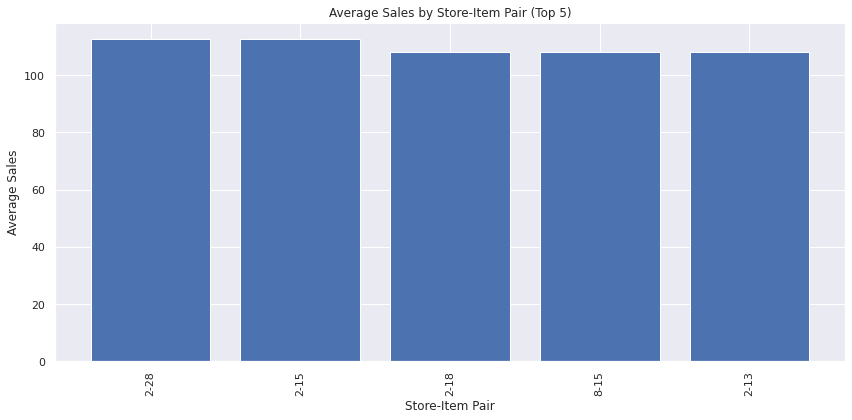

In [0]:
#Average sales for each group.
#df.groupby(["store", "item", "month"])["sales"].mean().head(36)

def plot_sales(df, plot_type="bar", agg_level="month", top_n=None):
    """
    Plots average sales data, optionally showing the top N combinations.
    """
    # Group by the specified level
    if agg_level == "month":
        sales_df = df.groupby("month")["sales"].mean().reset_index()
        xlabel = "Month"
    elif agg_level == "store":
        sales_df = df.groupby("store")["sales"].mean().reset_index()
        xlabel = "Store"
    elif agg_level == "item":
        sales_df = df.groupby("item")["sales"].mean().reset_index()
        xlabel = "Item"
    elif agg_level == "store-item":
        sales_df = df.groupby(["store", "item"])["sales"].mean().reset_index()
        sales_df['store-item'] = sales_df['store'].astype(str) + '-' + sales_df['item'].astype(str)
        xlabel = "Store-Item Pair"
    else:
        raise ValueError("Invalid aggregation level. Choose from: 'month', 'store', 'item', 'store-item'")

     # Filter out the aggregation levels with no sales
    sales_df = sales_df[sales_df["sales"] > 0]
    # Sort the data by sales in descending order and select the top n combinations
    if sales_df.shape[0] < top_n:
        top_n = sales_df.shape[0]
    sales_df = sales_df.sort_values(by="sales", ascending=False).head(top_n)    

    # Select top N combinations if top_n is specified
    #if top_n is not None:
    #    sales_df = sales_df.sort_values(by="sales", ascending=False).head(top_n)

    # Create the plot
    plt.figure(figsize=(12, 6))
    if plot_type == "bar":
        if agg_level == "store-item":
            plt.bar(sales_df['store-item'], sales_df["sales"])
        else:
            plt.bar(sales_df[agg_level], sales_df["sales"])
    elif plot_type == "line":
        if agg_level == "store-item":
            plt.plot(sales_df['store-item'], sales_df["sales"])
        else:
            plt.plot(sales_df[agg_level], sales_df["sales"])
    else:
        raise ValueError("Invalid plot type. Choose from: 'bar', 'line'")

    plt.xlabel(xlabel)
    plt.ylabel("Average Sales")
    plt.title(f"Average Sales by {xlabel.title()} (Top {top_n})" if top_n else f"Average Sales by {xlabel.title()}")
    plt.xticks(rotation=90 if agg_level == "store-item" else 0) 
    plt.tight_layout()
    plt.show()


plot_sales(df, plot_type="bar", agg_level="store-item", top_n=5) # Show top 5 store-item combo



## b) Random Noise

Random noise should be added to evaluate the overall performance of the model and to prevent overfitting

In [0]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

## c) Lag/Shifted Features

The purpose of lag features is to use past data points to predict future values. They help the model learn patterns and dependencies over time, improving the accuracy of forecasts.

In [0]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

## d) Rolling Mean Features
Rolling mean features help to smooth out short-term fluctuations in time series data, making it easier to identify long-term trends and patterns.

In [0]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

## e) Exponentially Weighted Mean Features
* __EWMA (Exponential Weighted Moving Average):__ Computes the weighted moving average of the data, where more recent data points receive higher weights.
* __Lag Features:__ Use past data to calculate the EWMA of historical values, helping to understand the dynamics of the data over time.
* __Alpha Parameter:__ Determines the weight given to past periods. Higher alpha values place more emphasis on recent data.


In [0]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

## f) One-Hot Encoding
We performed one-hot encoding because, as observed in the data analysis, the sales amounts for each store and item vary. To help our model understand this better, we used one-hot encoding with get_dummies."

In [0]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

## g) Converting sales to log(1+sales)
We applied a logarithmic transformation using log(1+sales) to make the model run more efficiently.

In [0]:
df['sales'] = np.log1p(df["sales"].values)

# 3) MODEL
## a) Custom Cost Function

In [0]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


 ## b) Time-Based Validation Sets

In [0]:
test.date.max(), test.date.min()

Out[103]: (Timestamp('2018-03-31 00:00:00'), Timestamp('2018-01-01 00:00:00'))

We selected the validation set within the range from January 1, 2017, to March 31, 2017, to best represent the time period we want to predict with our model, which covers from January 1, 2018, to March 31, 2018.

In [0]:
# Train set: Data up to the beginning of 2017 (end of 2016).
train = df.loc[(df["date"] < "2017-01-01"), :]

# Validation set: The first 3 months of 2017.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# Selecting features and target variables
cols = [col for col in train.columns if col not in ['date', 'id', 'sales', 'year']]

Y_train = train['sales']  # Target variable for the training set
X_train = train[cols]     # Feature variables for the training set

Y_val = val['sales']      # Target variable for the validation set
X_val = val[cols]         # Feature variables for the validation set

# Display the shapes of the target and feature variables for both training and validation sets
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

Out[104]: ((730500,), (730500, 141), (45000,), (45000, 141))

## c) Time Series Model Using LightGBM

First, hyperparameters were optimized using Random Search CV, followed by Grid Search CV to find the best hyperparameters.

In [0]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

# Train the model
model = lgb.train(
    lgb_params, 
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    callbacks=[lgb.early_stopping(lgb_params['early_stopping_rounds'])]
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072876 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds

In [0]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Out[106]: 13.83211807209558

## d) Feature Importance

feature split gain
16 sales_roll_mean_546 951 58.095440
12 sales_lag_364 1246 12.875756
15 sales_roll_mean_365 644 8.526995
59 sales_ewm_alpha_05_lag_365 372 4.625566
1 day_of_year 1007 2.987856
.. ... ... ...
106 item_35 0 0.000000
65 store_4 0 0.000000
114 item_43 0 0.000000
73 item_2 0 0.000000
70 store_9 0 0.000000

[141 rows x 3 columns]

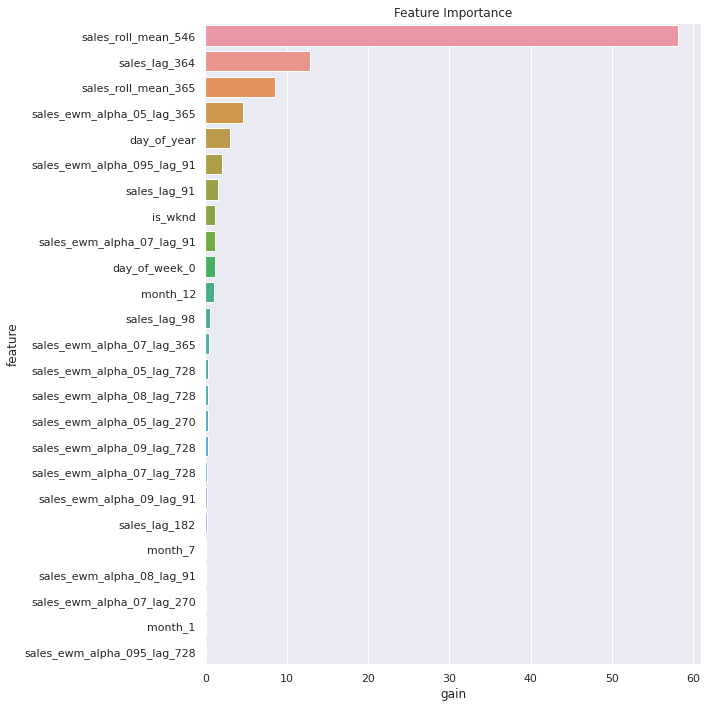

feature split gain
16 sales_roll_mean_546 951 58.095440
12 sales_lag_364 1246 12.875756
15 sales_roll_mean_365 644 8.526995
59 sales_ewm_alpha_05_lag_365 372 4.625566
1 day_of_year 1007 2.987856
.. ... ... ...
106 item_35 0 0.000000
65 store_4 0 0.000000
114 item_43 0 0.000000
73 item_2 0 0.000000
70 store_9 0 0.000000

[141 rows x 3 columns]
Out[107]: 112

In [0]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

# Plot the top 200 feature importances and display the top 30 features
plot_lgb_importances(model, num=200)
plot_lgb_importances(model, num=30, plot=True)

# Get the feature importances
feat_imp = plot_lgb_importances(model, num=200)

# Identify features with zero importance
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

# Filter out features with zero importance
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

When examining feature importance, it is evident that the features created during feature engineering have a significant impact on the model.

# 4) FINAL MODEL


In [0]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

### Submission File

In [0]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df
#submission_df.to_csv("submission_demand.csv", index=False)

Out[109]:

,id,sales
0,0,12.796675
1,1,13.828870
2,2,15.008808
3,3,15.303660
4,4,18.060158
...,...,...
44995,44995,70.664964
44996,44996,74.006835
44997,44997,78.301770
44998,44998,80.363707


In [0]:
message="100"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

message = "Job Execution Completed."
restworkflowcontext.outSuccess(9, title="Success", text=message)

Sending Message: {"progress": "100", "id": 9, "name": "Progress", "title": "Progress", "type": "progress", "resultType": 3, "visibility": "EXPANDED", "time": "Aug 19, 2024 10:04:47 AM"}
Not sending message to fire_notebook server as the post back URL is not http
Sending Message: {"text": "Job Execution Completed.", "id": 9, "name": "Success", "title": "Success", "type": "success", "resultType": 3, "visibility": "EXPANDED", "time": "Aug 19, 2024 10:04:47 AM"}
Not sending message to fire_notebook server as the post back URL is not http